<a href="https://colab.research.google.com/github/abbyWoot/AML/blob/master/AML_Project3_JiahuiWu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Advanced Machine Learning Project3

@student: Jiahui Wu Abby

The CIFAR-10 dataset consists of 5 batches, named data_batch_1, data_batch_2, etc. As stated in the official web site, each file packs the data using pickle module in python.

The original one batch data is (10000 x 3072) matrix expressed in numpy array. The number of columns, (10000), indicates the number of sample data.
The row vector, (3072) represents an color image of 32x32 pixels.

In [0]:
#Set Up. 
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline  #showes matplotlib images on notebook 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Load data from the CIFAR-10 datset

As mentionsed above, 32 X 32 is the size of each image. 
3 is the number of channels of the image. A RBG color image, has 3 channels.


In [10]:
from sklearn.datasets import fetch_openml 
#Was using fetch_mldata, and received an ImportError: cannot import name 'fetch_mldata' from 'sklearn.datasets
#using the tensflow to download the CIFAR-10 data
import tensorflow as tf
(X_train, y_train), (X_test, y_test)=tf.keras.datasets.cifar10.load_data()
print(f"Length of the X_train: {X_train.shape}, Length of y_train is: {y_train.shape}")
print(f"Length of the X_test:{X_test.shape}, Length of y_test is{y_test.shape}")

Length of the X_train: (50000, 32, 32, 3), Length of y_train is: (50000, 1)
Length of the X_test:(10000, 32, 32, 3), Length of y_test is(10000, 1)


tf.keras.datasets.cifar10.load_data() returns 2 tuples:

1, x_train, x_test: unit8 array of RGB image data with shape (number_samples, 3, 32, 32) or (number_samples, 32, 32, 3) based on the image_data_format backend setting of either channels_first or channels_last respectively.

2, y_train, y_test: uint8 array of category labels (integers in range 0-9) with shape (num_samples, 1).

In [0]:
#Convert the X_train and X_test data into 2d array:
nsamples, nx, ny,nz = X_train.shape
d2_X_train = X_train.reshape((nsamples,nx*ny*nz))
nsamples, nx, ny, nz = X_test.shape
d2_X_test = X_test.reshape((nsamples,nx*ny*nz))

In [18]:
#Train the Random Forest Classifier and capture the time taken to train the orginal model
#import library
from sklearn.ensemble import RandomForestClassifier
import time
#initial the model
rnd_clf = RandomForestClassifier()
start_time = time.time()
#Train the model
rnd_clf.fit(d2_X_train, y_train)
print("Time is taken by model:","— %s seconds —"% (time.time()-start_time))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Time is taken by model: — 278.82897996902466 seconds —


In [19]:
#Perfom the prediction on test data
y_predict = rnd_clf.predict(d2_X_test)

#Measure the accurancy of the Classifier
from sklearn.metrics import accuracy_score
print(f"Accuracy is {accuracy_score(y_predict, y_test) * 100}%")

Accuracy is 46.54%


use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%.

In [20]:
#Use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%
from sklearn.decomposition import PCA
pca = PCA(n_components = .95) #This will insure that 95% variance is covered
X_train_reduced = pca.fit_transform(d2_X_train)

#Verify the redued shape before we start training new model
print(f"X_train shape is {d2_X_train.shape} and X_train_reduced shape is {X_train_reduced.shape}")

X_train shape is (50000, 3072) and X_train_reduced shape is (50000, 217)


In [21]:
start_time2 = time.time() 
rnd_clf.fit(X_train_reduced, y_train) #Train the model 
print("Time is taken by model:","— %s seconds —"% (time.time()-start_time2))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Time is taken by model: — 125.93982768058777 seconds —


In [22]:
X_test_reduced = pca.transform(d2_X_test) #Reduce the dimensionality first
y_predict2 = rnd_clf.predict(X_test_reduced) #Predic the values using Model
print(f"Accuracy is {accuracy_score(y_predict2, y_test)* 100} %") #Print the accuracy

Accuracy is 43.769999999999996 %


In [0]:
# normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

Just for fun

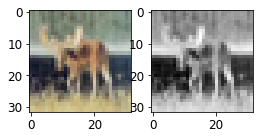

In [32]:
def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

X_train_gray = grayscale(X_train)
X_test_gray = grayscale(X_test)

# now we have only one channel in the images
img_channels = 1

# plot a randomly chosen image
img = 28  #image number
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(X_train[img], interpolation='none')
plt.subplot(1, 2, 2)
plt.imshow(X_train_gray[img, :, :, 0], cmap=plt.get_cmap('gray'), interpolation='none')
plt.show()